## Corrected $C_m $ and further explorations
Simulations using the correct value $C_m$ = 100pF. \
This allowed for reduced amplitude compared to the simulations using $C_m$ = 150pF


In [11]:
%matplotlib inline

import numpy as np
from numpy import random
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
import itertools
import seaborn as sns
import os
print(os.getcwd())
import sys
Path = os.getcwd()
sys.path.append(Path)
from build_network import *
from utilities1 import *



/mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks


In [12]:
def plot_results(sim_time=5000, noisy=False, delay_mean=1.0, delay_sd=0.25, weight=1,
                 second_sine=False,xLim=1, y_min=1e-12,a_values=[100], SD_values=[250],
                 f_values=[10], beat=20, E_m=-60, V_th=-50, bin_size=0.25, tau_m=10,
                 seed=np.random.randint(0,1e+6), resolution=0.25, num_A=1000, common_noise=False,
                 log=True, harmonics=1, harmonics_beat=0, V_thresh=-50,tau_syn_ex=2,
                 measure_from_A=False, seed_check=False, neuron_type="iaf_psc_alpha"):
    """This function plots:
    - Membrane potential as a function of time for a given length within simulation time (xLim)
    - The PSD of the spike train
    - The PSD of the membrane potential
        noisy: whether to include noise or not (True/False)
        sim_time: duration of simulation (ms)
        psd_segments: number of segments in welch psd
        second_sine : whether to include second AC generator or not (True/False)
        xLim : limiting the time axis of the membrane potential (max value) (ms)
        a_values : input amplitudes (pA)
        SD_values : input noise level (standard deviation) (pA)
        f_values : input frequencies (Hz)
        beat : frequency offset (Hz)
        E_m : resting potential (mV)
        V_th : Threshold for firing action potentials (mV)
        bin_size : width of frequency (Hz)
        seed : random number (or set by user for control).
        Necessary for generation of stochastic noise,
        resolution : temporal resolution/length of time steps (ms)
        legend : Whether to put legend outside plots (True/False)
        log : Whether to use loglog-plot or not (True/False)
        y_min : min value for PSD of spike train (varies a lot)
        harmonics : number of harmonics of input frequencies indicated in PSD-plot
        harmonics_beat : number of harmonics of beat frequency indicated in PSD- plot
        measure_from_A : whether to measure from a neuron in population A instead of B (True/False)
        seed_check : whether to plot membrane potentials for two neurons in pop. A (True/False)"""

    
    ###*************************SIMULATION**************************************
    if noisy:
        param_combos = list(itertools.product(f_values,a_values, SD_values))
        
    else:
        param_combos = list(itertools.product(f_values, a_values))
    
    param_combos = np.atleast_1d(param_combos) #to allow for one single combination
    
    
    fig, axes = plt.subplots(nrows=len(param_combos), ncols=3, 
                             figsize=(15, 4*len(param_combos)))
    
    if len(param_combos) == 1:
        axes = np.array([axes])
    
    for idx, combo  in enumerate(param_combos):
        if noisy:
            f, a, sd = combo  
            results = build_network(sim_time=sim_time, noisy=noisy, second_sine=second_sine, V_thresh=V_th,
                                        f1=f, beat=beat, a=a, SD=sd, tau_m=tau_m, num_A=num_A, weight=weight,
                                        seed=seed, resolution=resolution, measure_from_A=measure_from_A, common_noise=common_noise,
                                        delay_mean=delay_mean, delay_sd=delay_sd, tau_syn_ex=tau_syn_ex) 
            
        else:
            f,a = combo
            results = build_network(sim_time=sim_time, noisy=noisy, second_sine=second_sine, V_thresh=V_th,
                                        f1=f, beat=beat, a=a, tau_m=tau_m, num_A=num_A, weight=weight,
                                        seed=seed, resolution=resolution, measure_from_A=measure_from_A, 
                                        delay_mean=delay_mean, delay_sd=delay_sd, tau_syn_ex=tau_syn_ex) 
            
            
         #********************************RESULTS AND PLOTS********************************   
        spike_times = results["spike_times"]
        Vm = results["Vm"]
        V_th = results["V_th"]
        sim_time = results["sim_time"]
        times = results["times"]
        tot_spike_rate = results["tot_spike_rate"]
        
        
        # Layout
        sns.set_style("whitegrid")
        plt.rcParams["font.family"] = "Liberation Serif"
        
        # Membrane potential with threshold 
       
        ax_vm = axes[idx,0]
            
        time_axis = np.linspace(0,sim_time,len(Vm))
        
        for t in spike_times:
            ax_vm.vlines(x=t, ymin=V_th, ymax=V_th+5, color="black") 
            
        ax_vm.plot(times, Vm, color='#006D5B')
        ax_vm.axhline(V_th, linestyle='-', color='black', label="V_th")  # terskel-linje
        
        
        # Setting title based on configuration of simulation
        letters = "ABCDEFGHIJKLMN"
        
        if noisy:
            if second_sine:
                ax_vm.set_title(
                rf"{letters[idx*3]}. Vm ($f_1$ = {f:.0f}Hz, $f_2$ = {f + beat :.0f}Hz, " +
                rf"$I_{{\mathrm{{amp}}}}$ = {a:.0f}pA)",
                fontsize=16, fontweight='bold', color="#006D5B"
                )
            else:
                ax_vm.set_title(
                rf"{letters[3*idx]}. Vm ($f$ = {f:.0f}Hz, $\sigma_I$ = {sd:.0f}pA, " +
                rf"$I_{{\mathrm{{amp}}}}$ = {a:.0f}pA)",
                fontsize=16, fontweight='bold', color="#006D5B"
                )
        else:
            if second_sine:
                ax_vm.set_title(
                rf"{letters[3*idx]}. Vm ($f_1$ = {f:.0f}Hz, $f_2$ = {f + beat:.0f}Hz, " +
                rf"$I_{{\mathrm{{amp}}}}$ = {a:.0f}pA)",
                fontsize=16, fontweight='bold', color="#006D5B"
                )
            else:
                ax_vm.set_title(
                rf" Vm ($f$ = {f:.0f}Hz, $I_{{\mathrm{{amp}}}}$ = {a:.0f}pA)",
                fontsize=16, fontweight='bold', color="#006D5B")
                
                
            # removing frequencies from the title if the input amplitude is zero
        if a == 0:
            title = title.replace(r"($f$ = " + f"{f:.0f}" + r"Hz, ", "(")
            title = title.replace(r"($f_1$ = " + f"{f:.0f}" + r"Hz, $f_2$ = " + f"{f + beat:.0f}" + r"Hz, ", "(")

            
        ax_vm.set_xlim([1000, 1000+xLim*1000])
        if np.all(Vm!=-60):
            ax_vm.set_ylim([np.min(Vm)-5,np.max(Vm)+10])
        else:
            ax_vm.set_ylim(np.min(Vm)-5, np.max(Vm)+10)
        ax_vm.set_xlabel("Time [ms]", color="#006D5B", fontsize=16)
        ax_vm.set_ylabel(r"$V_\mathrm{m}\, [\mathrm{mV}]$", color="#006D5B", fontsize=16)
        
        #chat-gpt:
        plot_layout(ax_vm)

        # PSD of spike train
        freqs, psd_values = psd(spike_times, sim_time, bin_size)
        freqs = freqs[50:]
        psd_values = psd_values[50:]
        arg_f = np.argmin(np.abs(freqs - f))
        
        if second_sine:
            arg_beat = np.argmin(np.abs(freqs - beat))
        else:
            arg_beat = None
        
        ax_fft = axes[idx,1]
        
        # Vertical lines indicating harmonics, colors filled in by chat GPT
        beat_colors = ["teal", "#1E3A8A", "#2563EB", "#60A5FA", "#38BDF8"] #Blue colors for beat frequencies
        colors = ["#009879", "#4CAF50", "#8BC34A", "#CDDC39", "#FFEB3B", "#FF9800","#F4E91E63","#9C27B0","#673AB7", 
    "#3F51B5"] # Green colors for harmonics
        
        for i in range(1,harmonics_beat+1):
            ax_fft.axvline(i*beat, linestyle="--", dashes=(2, 5), color=beat_colors[i], label=f"f={i*beat}Hz")
            
        for i in range(1,harmonics+1):
            ax_fft.axvline(i*f, linestyle="--", dashes=(2, 5), color=colors[i], label=f"{i*f}Hz")
            if second_sine:
                ax_fft.axvline(i*(f+beat), linestyle="--", dashes=(2, 5), color=colors[i+harmonics], label=f"{i*(f+beat)}Hz")
            ax_fft.legend()
        
        ax_fft.plot(freqs, psd_values, color="#006D5B") 
        
        xMax = max(f,np.max(freqs))*1.1
        if log:
            ax_fft.set_xscale("log")
            ax_fft.set_yscale("log")
            # xticks and yticks
            ax_fft.xaxis.set_major_locator(LogLocator(base=10.0)) 
            ax_fft.yaxis.set_major_locator(LogLocator(base=10.0))
            
        ax_fft.set_xlabel("Frequency (Hz)", color="#006D5B", fontsize=16)
        ax_fft.set_ylabel(r'PSD [$\mathrm{spikes}^2/\mathrm{Hz}$]', color="#006D5B", fontsize=16)
        ax_fft.set_title(f"{letters[1+3*idx]}. PSD of spike train", fontsize=18, fontweight='bold', color="#006D5B")
        
        plot_layout(ax_fft)
        
        # table of important values
        if noisy:
            if second_sine == False:
                beat = 0
            df, noise_avg = simulated_SNR(Vm, a, psd_values, f, freqs, 
                                          arg_f, sim_time, sd, beat, spike_times, second_sine)
                      
            df["Population spike-rate"] = tot_spike_rate
            display(df)
    
    
        # PSD of membrane potential
        freqs, fft_vm = psd_Vm(Vm, times, bin_size)
        fft_vm = np.abs(fft_vm)
        
        ax_fft_vm = axes[idx,2]
        for i in range(1,harmonics_beat+1):
            ax_fft_vm.axvline(i*beat, linestyle="--", dashes=(2, 5), color=beat_colors[i], label=f"{i*beat}Hz")
            
        for i in range(1,harmonics+1):
            ax_fft_vm.axvline(i*f, linestyle="--", dashes=(2, 5), color=colors[i], label=f"{i*f}Hz")
            if second_sine:
                ax_fft_vm.axvline(i*(f+beat), linestyle="--", dashes=(2, 5), color=colors[i+harmonics], label=f"{i*(f+beat)}Hz")
            
        ax_fft_vm.legend()    
        ax_fft_vm.plot(freqs, np.abs(fft_vm), color='#006D5B')  
        ymin = max(y_min, np.min(np.abs(fft_vm)))
        ax_fft_vm.set_ylim(ymin,10*np.max(np.abs(fft_vm)))
        ax_fft_vm.set_xlabel("Frequency [Hz]", color="#006D5B", fontsize=16)
        ax_fft_vm.set_ylabel(r'PSD [$(\mathrm{mV})^2/\mathrm{Hz}$]', color="#006D5B", fontsize=16)
        ax_fft_vm.set_title(f"{letters[2+3*idx]}. PSD of $V_m$", fontsize=20, fontweight='bold', color="#006D5B")
        if np.any(Vm!=-60): 
            ax_fft_vm.set_xscale("log")
            ax_fft_vm.set_yscale("log")
            ax_fft_vm.xaxis.set_major_locator(LogLocator(base=10.0))
            ax_fft_vm.yaxis.set_major_locator(LogLocator(base=10.0))
        
  

## Receiving neuron

Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/B_main_77.png


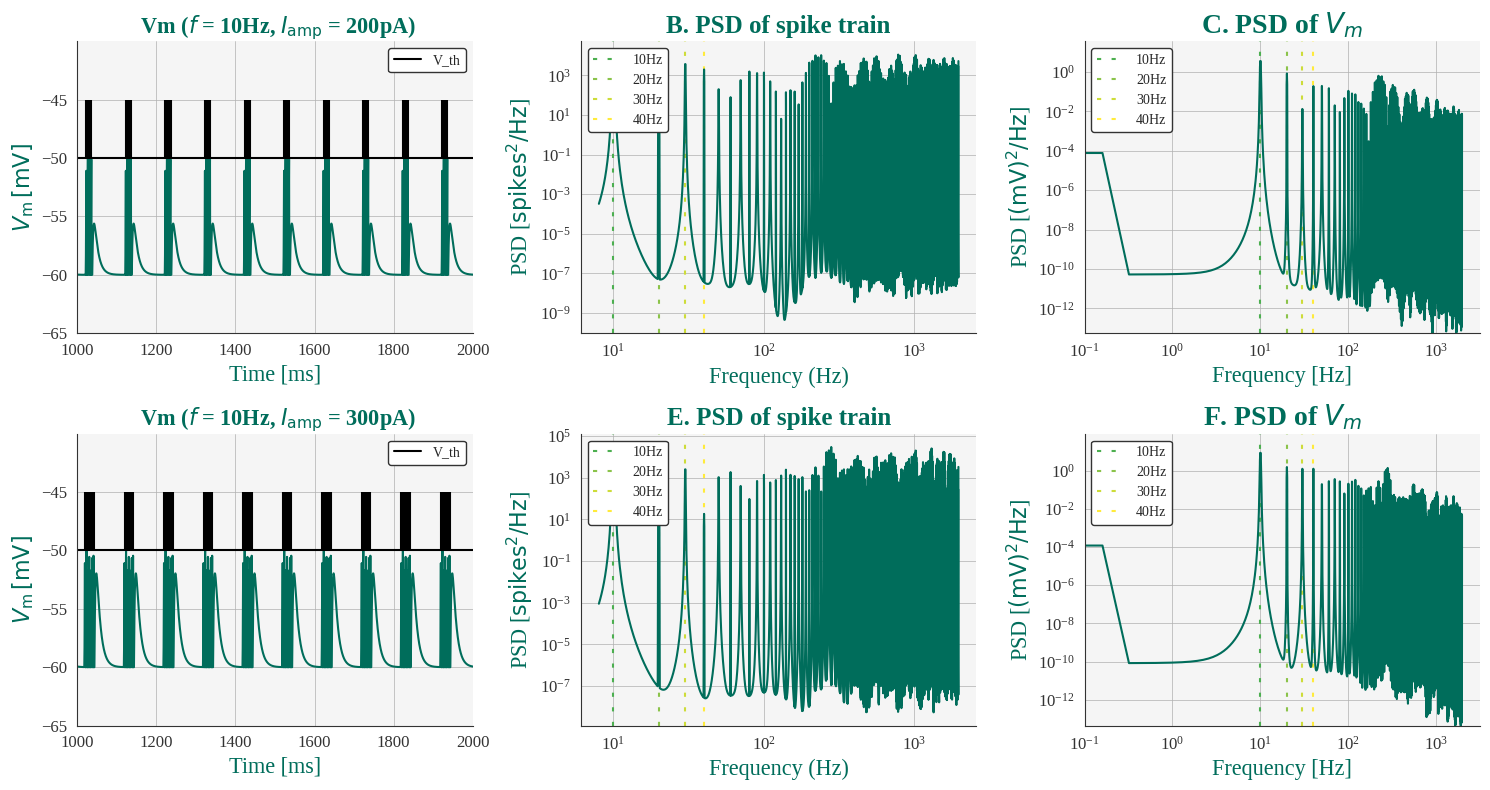

In [6]:
"""f1=10Hz, f2=30Hz"""
plot_results(sim_time=100e3, delay_sd=0.25, delay_mean=1,
             a_values=[200,300], V_th=-50, f_values=[10],
             noisy=False, SD_values=[0],num_A=1000, y_min=1e-15,
             bin_size=0.25,xLim=1,second_sine=False, harmonics=4,
             log=True, resolution=0.25)


May 18 12:08:31 correlospinmatrix_detector [Info]: 
    Default for delta_tau changed from 0.1 to 0.25 ms

May 18 12:08:31 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.25 ms.


,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat),Population spike-rate
0,"[10, 30]",20,50,-50.000112,453.34,453.34,17.33,9.92,15.69,28.89,15.06,5.2,28.9,6376.09


,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat),Population spike-rate
0,"[10, 30]",20,100,-50.00001,4843.72,4829.78,18.43,10.08,34.81,138.73,45.37,18.3,138.7,16603.62


Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/B_main_77.png


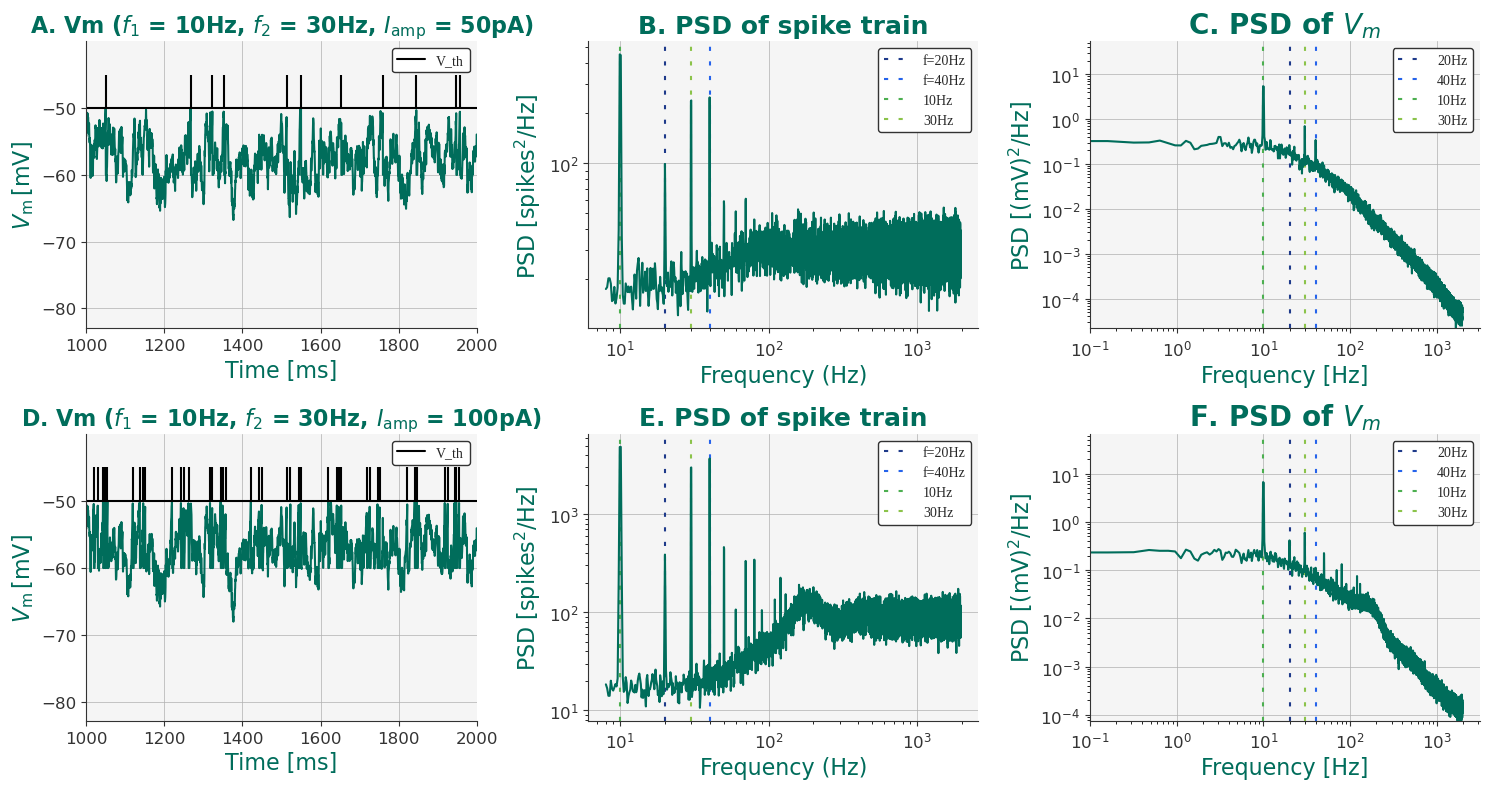

In [3]:
"""f1=100Hz, f2=120Hz"""
plot_results(sim_time=100e3,
             a_values=[50, 100],f_values=[10], delay_sd=0.25, delay_mean=1,
             noisy=True, SD_values=[250],num_A=1000, seed=5,
             bin_size=0.25,xLim=1,second_sine=True, beat=20, harmonics_beat=2,harmonics=1,
             log=True, resolution=0.25)

,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat),Population spike-rate
0,"[1000, 1020]",20,500,-50.000016,24.62,14.75,10.47,1650.24,1.23,11.95,6.04,1.5,12.0,3407.47


,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat),Population spike-rate
0,"[1000, 1020]",20,1000,-50.000109,67.14,24.03,14.89,20.0,1.11,21.62,10.78,3.3,21.6,5816.47


Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/B_main_77.png


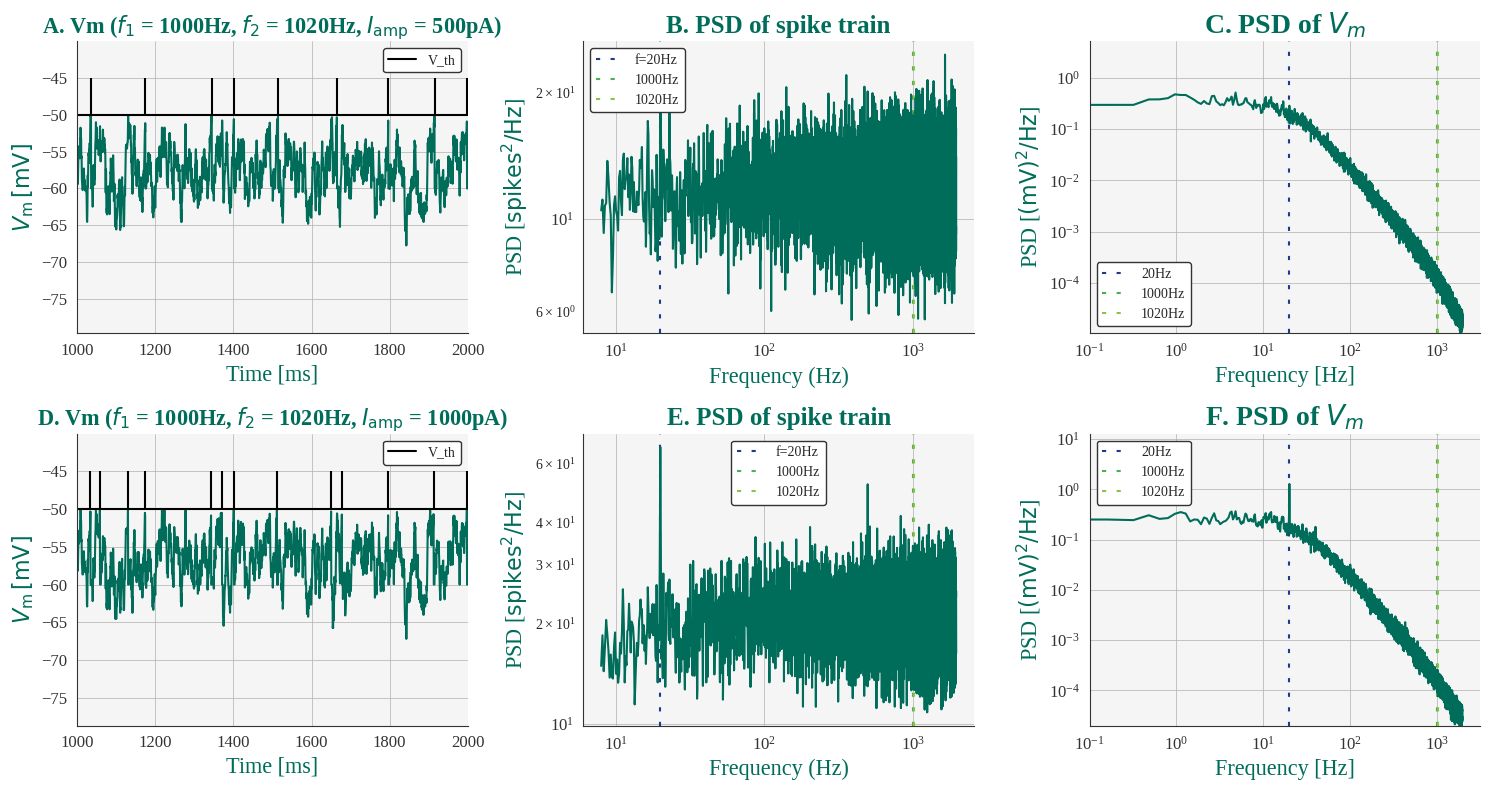

In [4]:
"""delay = 0.25ms."""
plot_results(sim_time=100e3,
             a_values=[500, 1000],f_values=[1000], delay_sd=0.25, delay_mean=5,
             noisy=True, SD_values=[250],num_A=1000,
             bin_size=0.25,xLim=1,second_sine=True, beat=20, harmonics_beat=1,harmonics=1,
             log=True, resolution=0.25)

,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat),Population spike-rate
0,"[1000, 1020]",20,500,-50.000774,21.93,14.01,10.97,1842.4,1.19,11.75,6.01,1.5,11.8,3407.47


,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat),Population spike-rate
0,"[1000, 1020]",20,1000,-50.000064,63.51,19.9,14.1,20.0,0.94,21.1,10.73,3.2,21.1,5816.47


Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/B_main_77.png


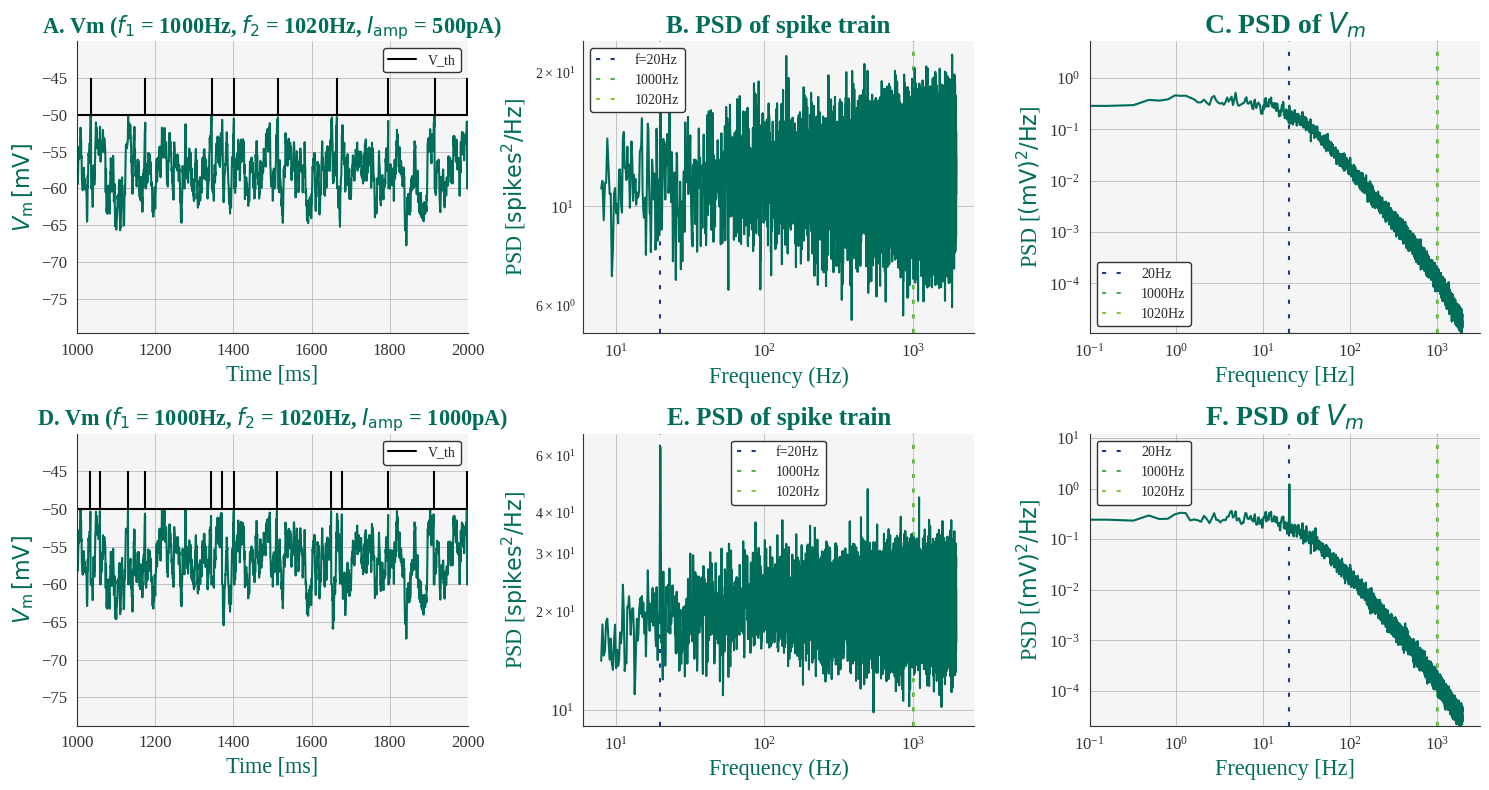

In [5]:
"""delay = 2ms."""
plot_results(sim_time=100e3,
             a_values=[500, 1000],f_values=[1000], delay_sd=2, delay_mean=5,
             noisy=True, SD_values=[250],num_A=1000,
             bin_size=0.25,xLim=1,second_sine=True, beat=20, harmonics_beat=1,harmonics=1,
             log=True, resolution=0.25)

,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat),Population spike-rate
0,"[1000, 1020]",20,500,-50.000923,22.31,13.04,9.33,1946.72,1.1,11.88,5.96,1.8,11.9,3407.47


,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat),Population spike-rate
0,"[1000, 1020]",20,1000,-50.001009,70.44,32.4,14.95,20.0,1.55,20.96,10.42,3.8,21.0,5816.47


Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/B_main_77.png


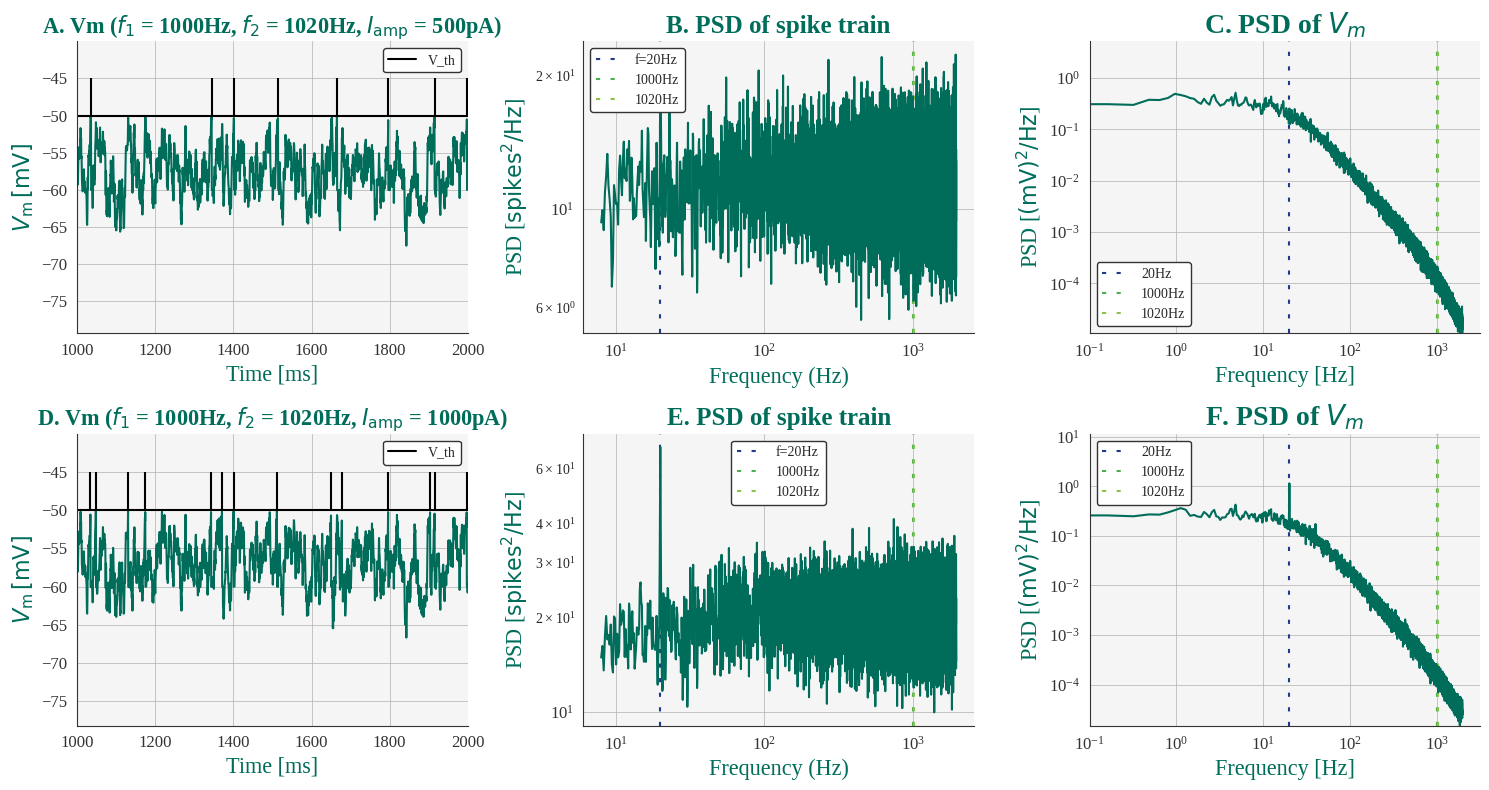

In [8]:
"""delay = 0"""
plot_results(sim_time=100e3,
             a_values=[500, 1000],f_values=[1000], delay_sd=0, delay_mean=1,
             noisy=True, SD_values=[250],num_A=1000,
             bin_size=0.25,xLim=1,second_sine=True, beat=20, harmonics_beat=1,harmonics=1,
             log=True, resolution=0.25)

,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat),Population spike-rate
0,"[1000, 1020]",20,1000,-50.000327,39.66,34.16,18.2,660.64,1.6,21.4,10.5,1.5,21.4,5811.65


Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/B_main_77.png


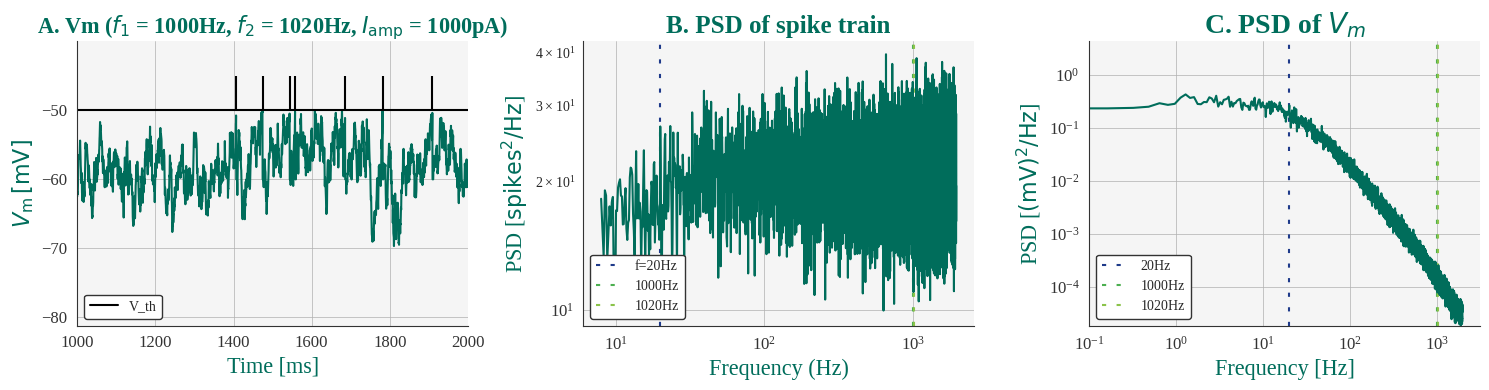

In [8]:
"""delay = 12ms."""
plot_results(sim_time=100e3,
             a_values=[1000],f_values=[1000], delay_sd=12, delay_mean=50,
             noisy=True, SD_values=[250],num_A=1000,
             bin_size=0.25,xLim=1,second_sine=True, beat=20, harmonics_beat=1,harmonics=1,
             log=True, resolution=0.25)

,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat),Population spike-rate
0,"[1000, 1020]",20,1000,-50.000088,39.98,24.84,15.86,1133.92,1.15,21.53,10.7,2.1,21.5,5811.65


Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/B_main_77.png


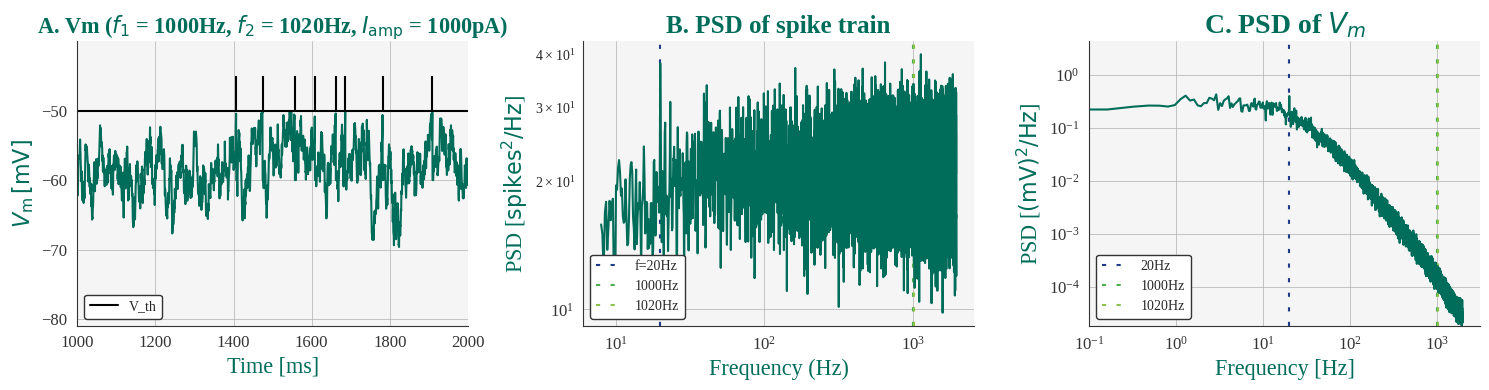

In [9]:
"""delay = 10ms."""
plot_results(sim_time=100e3,
             a_values=[1000],f_values=[1000], delay_sd=10, delay_mean=50,
             noisy=True, SD_values=[250],num_A=1000,
             bin_size=0.25,xLim=1,second_sine=True, beat=20, harmonics_beat=1,harmonics=1,
             log=True, resolution=0.25)

# Further explorations after thesis submission: 

## iaf_psc_exp

,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat),Population spike-rate
0,"[1000, 1020]",20,1000,-50.000209,74.86,15.65,19.7,20.0,0.74,21.03,10.61,3.8,21.0,5812.45


Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/B_main_77.png


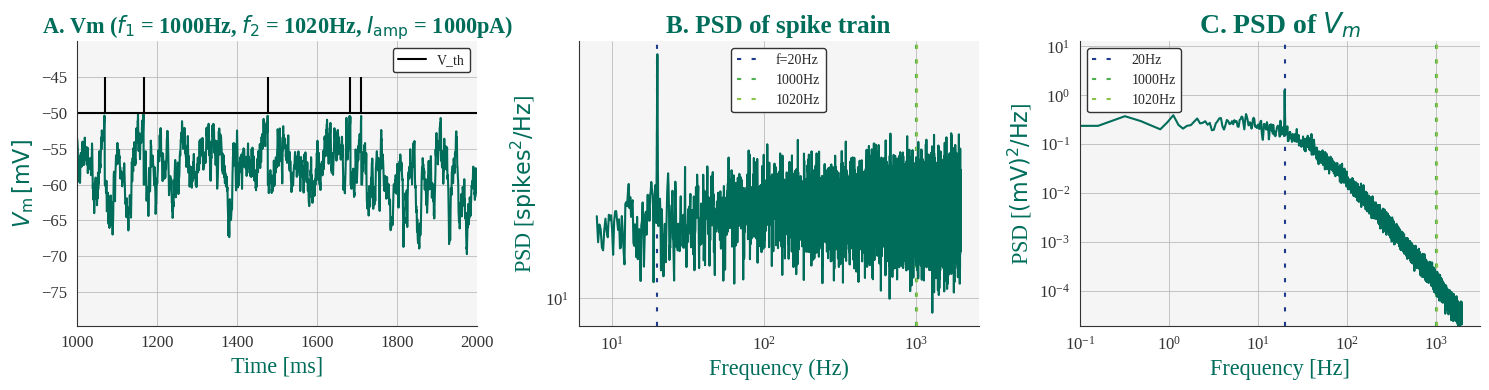

In [4]:
"""Testing out iaf_psc_exp - exponential decay instead of alpha. delay=0.25"""
plot_results(sim_time=100e3,
             a_values=[1000],f_values=[1000], delay_sd=0.25, delay_mean=1,
             noisy=True, SD_values=[250],num_A=1000,
             bin_size=0.25,xLim=1,second_sine=True, beat=20, harmonics_beat=1,harmonics=1,
             log=True, resolution=0.25, neuron_type="iaf_psc_exp")

,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat),Population spike-rate
0,"[1000, 1020]",20,1000,-50.000665,60.44,24.55,16.18,20.0,1.19,20.65,9.96,3.7,20.7,5814.47


Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/B_main_77.png


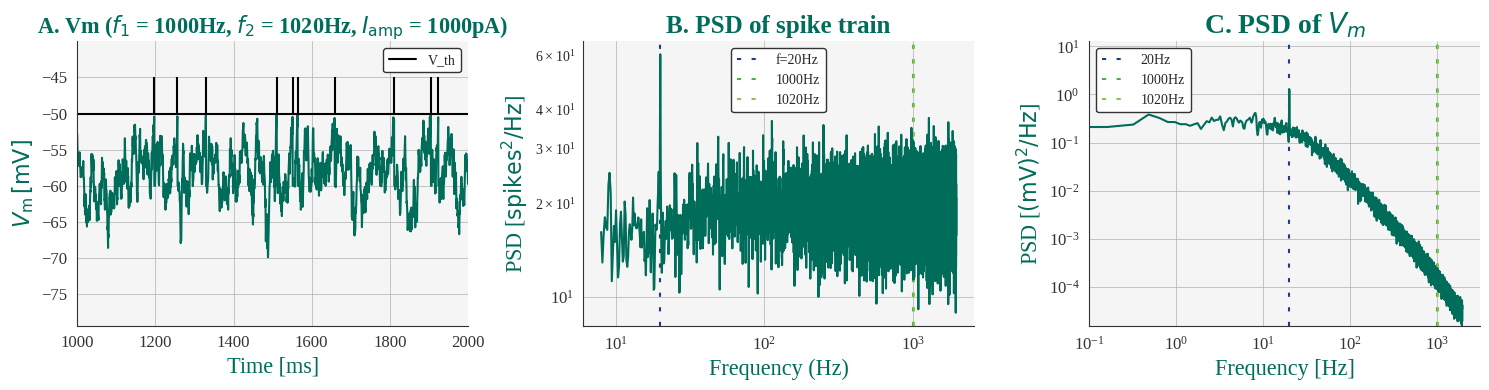

In [6]:
"""Testing iaf_psc_exp -  exponential decay instead of alpha. 
    and decreasing tau_syn_ex. delay=0.25"""

plot_results(sim_time=100e3, tau_syn_ex=2,
             a_values=[1000],f_values=[1000], delay_sd=0.25, delay_mean=1,
             noisy=True, SD_values=[250],num_A=1000,
             bin_size=0.25,xLim=1,second_sine=True, beat=20, harmonics_beat=1,harmonics=1,
             log=True, resolution=0.25, neuron_type="iaf_psc_exp")

## decreasing tau_syn_ex : rise time of PSC. keeping charge constant by scaling the weight by $\frac{\tau_{syn,ex,i}}{\tau_{syn,ex,f}}$

,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat),Population spike-rate
0,"[1000, 1020]",20,1000,-50.000564,70.14,23.37,26.9,20.0,1.14,20.42,10.63,3.9,20.4,5804.15


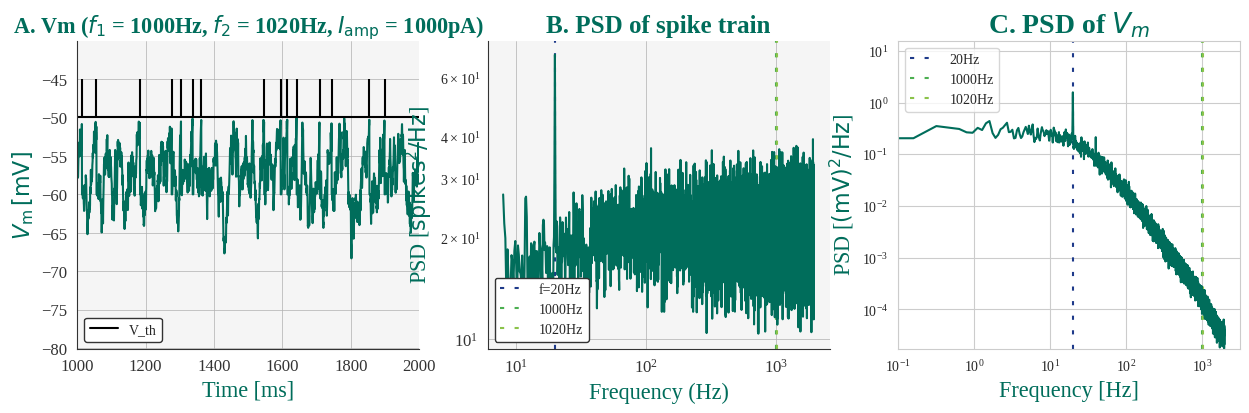

In [8]:
"""Testing iaf_psc_exp -  exponential decay instead of alpha. 
    and decreasing tau_syn_ex to 0.5 ms, scaling the weight by 4 
    to get the same amount of charge as in previous simulations.
    delay=0.25"""

plot_results(sim_time=100e3, tau_syn_ex=0.5,
             a_values=[1000],f_values=[1000], delay_sd=0.25, delay_mean=50,
             noisy=True, SD_values=[250],num_A=1000, weight=4,
             bin_size=0.25,xLim=1,second_sine=True, beat=20, harmonics_beat=1,harmonics=1,
             log=True, resolution=0.25, neuron_type="iaf_psc_exp")

,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat),Population spike-rate
0,"[1000, 1020]",20,1000,-50.000506,67.78,19.48,26.29,20.0,0.92,21.08,10.65,3.7,21.1,5804.15


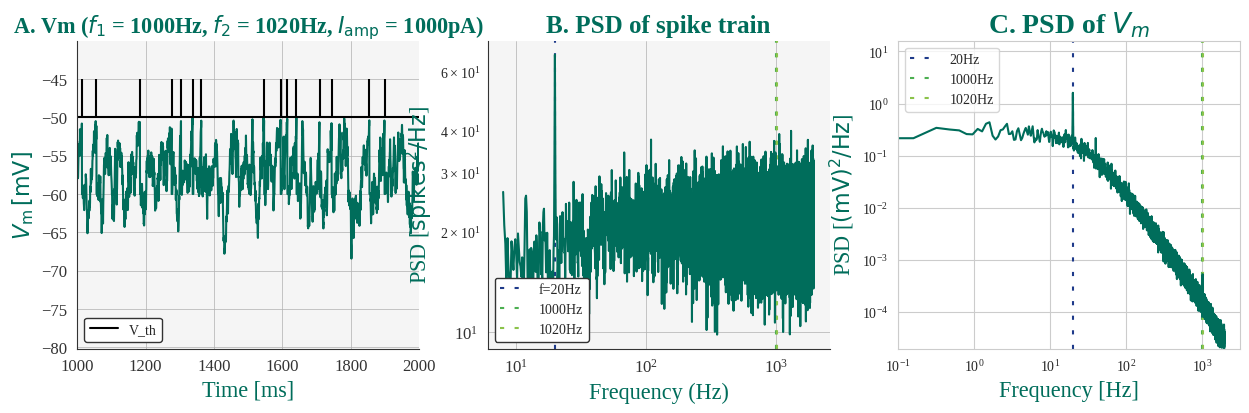

In [9]:
plot_results(sim_time=100e3, tau_syn_ex=0.1,
             a_values=[1000],f_values=[1000], delay_sd=0.25, delay_mean=50,
             noisy=True, SD_values=[250],num_A=1000, weight=20,
             bin_size=0.25,xLim=1,second_sine=True, beat=20, harmonics_beat=1,harmonics=1,
             log=True, resolution=0.25, neuron_type="iaf_psc_exp")

,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat),Population spike-rate
0,"[1000, 1020]",20,1000,-50.000352,64.41,20.68,26.3,20.0,1.03,20.1,10.49,3.6,20.1,5804.15


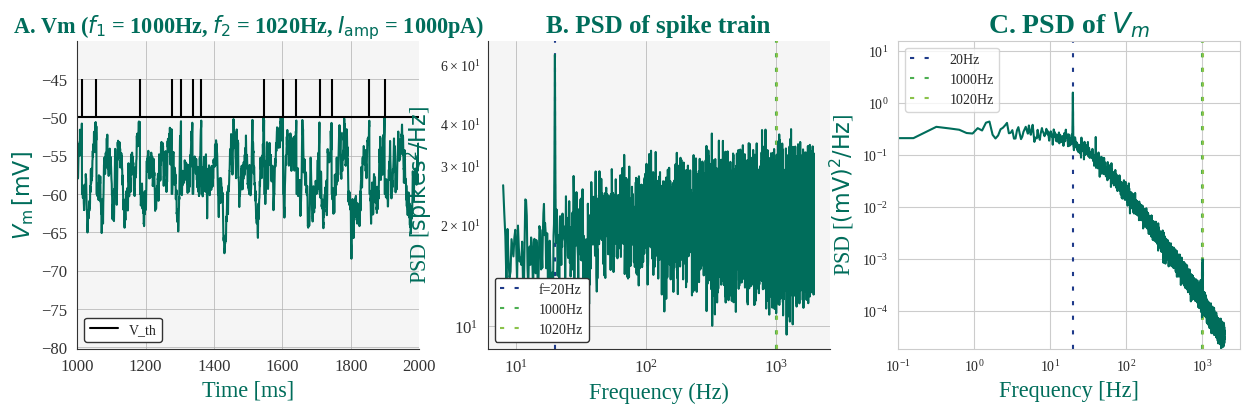

In [10]:
plot_results(sim_time=100e3, tau_syn_ex=0.01,
             a_values=[1000],f_values=[1000], delay_sd=0.25, delay_mean=50,
             noisy=True, SD_values=[250],num_A=1000, weight=200,
             bin_size=0.25,xLim=1,second_sine=True, beat=20, harmonics_beat=1,harmonics=1,
             log=True, resolution=0.25, neuron_type="iaf_psc_exp")

## what about the delta function?

,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat),Population spike-rate
0,"[1000, 1020]",20,1000,-50.000057,82.87,18.09,14.08,20.0,0.83,21.69,10.74,4.3,21.7,5811.81


Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/B_main_77.png


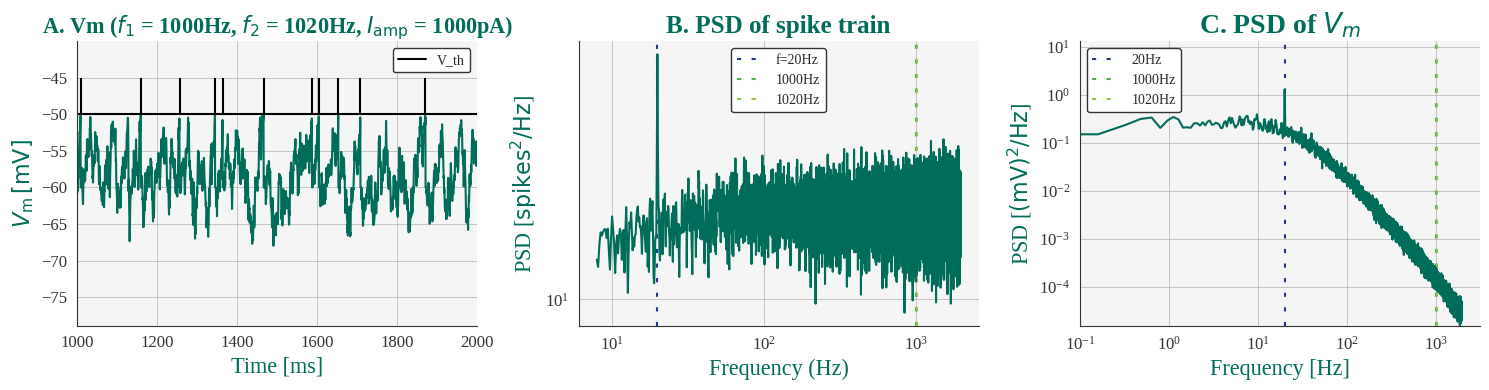

In [10]:
plot_results(sim_time=100e3, tau_syn_ex=0.5,
             a_values=[1000],f_values=[1000], delay_sd=0.25, delay_mean=5,
             noisy=True, SD_values=[250],num_A=1000, weight=4,
             bin_size=0.25,xLim=1,second_sine=True, beat=20, harmonics_beat=1,harmonics=1,
             log=True, resolution=0.25, neuron_type="iaf_psc_delta")

As long as the amount of charge is held constant, the shape of the epsp does not matter. 
the charge and the delay is important to keep the signal dominance of the beat frequency. 

,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat),Population spike-rate
0,"[1000, 1020]",20,1000,-50.000231,74.71,22.74,16.45,20.0,1.03,22.01,11.03,3.9,22.0,5811.65


Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/B_main_77.png


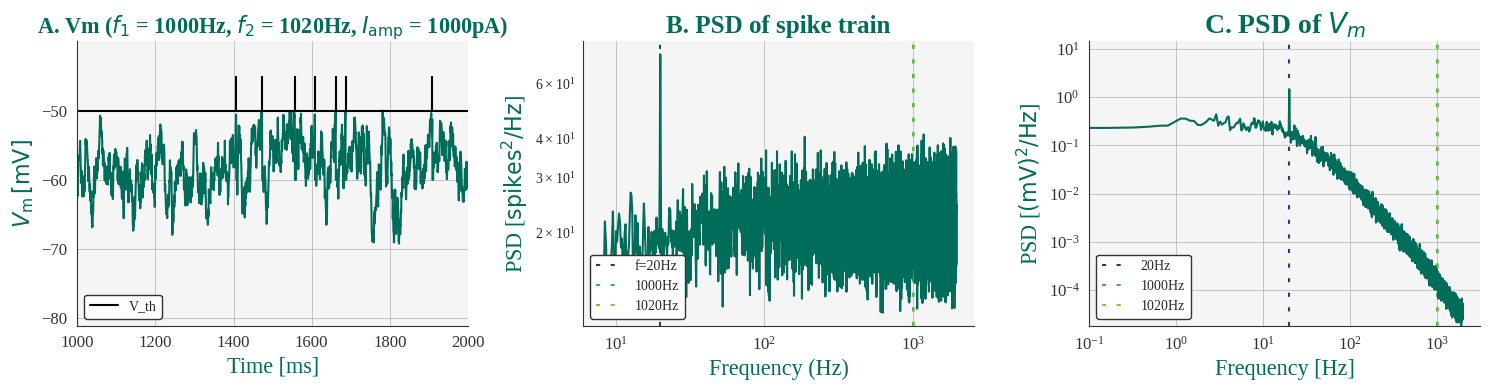

In [10]:
plot_results(sim_time=100e3, tau_syn_ex=0.5, tau_m = 0.5,
             a_values=[1000],f_values=[1000], delay_sd=0.25, delay_mean=1,
             noisy=True, SD_values=[250],num_A=1000, weight=4,
             bin_size=0.25,xLim=1,second_sine=True, beat=20, harmonics_beat=1,harmonics=1,
             log=True, resolution=0.25, neuron_type="iaf_psc_delta")

## iaf_psc_alpha - does noise play a key role in the biophysical mechanism? 

/tmp/ipykernel_609/1889300356.py:171: UserWarning:Data has no positive values, and therefore cannot be log-scaled.


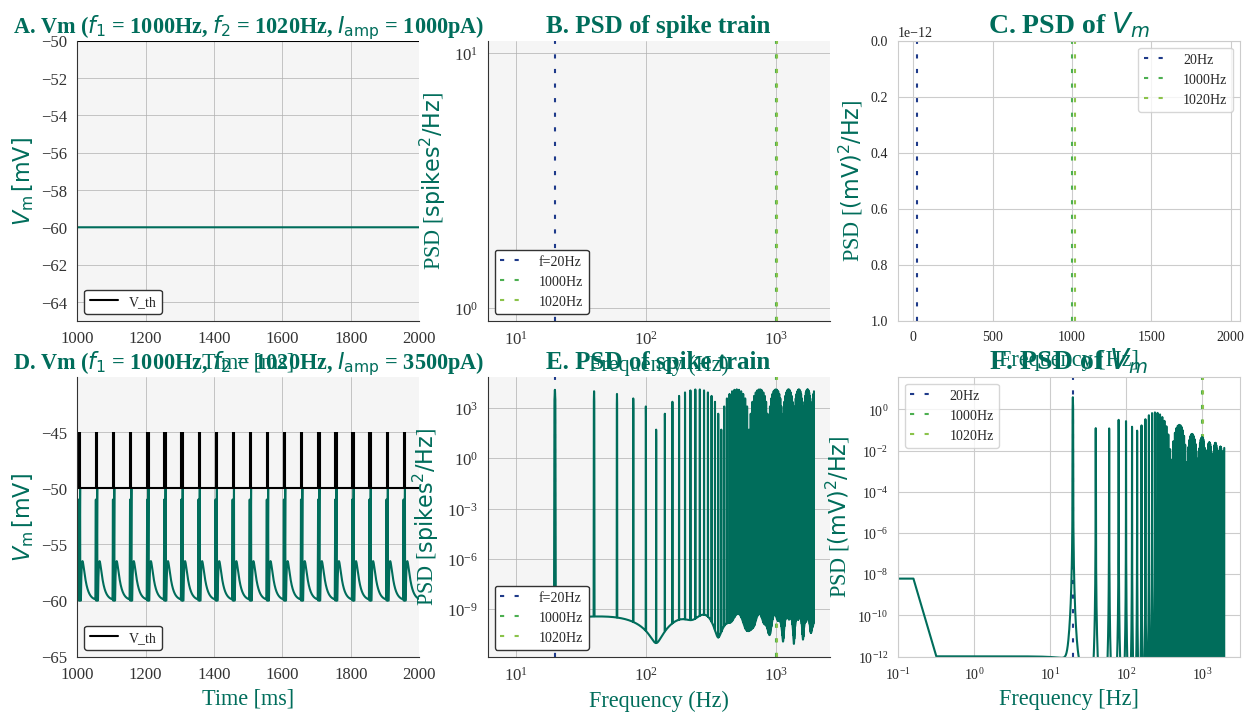

In [21]:
"""Common noise. iaf_psc_alpha. delay=0.25"""
plot_results(sim_time=100e3, tau_syn_ex=2, tau_m = 10,
             a_values=[1000,3500],f_values=[1000], delay_sd=0, delay_mean=10,
             noisy=False, SD_values=[250],num_A=1000, weight=1, common_noise=True,
             bin_size=0.25,xLim=1,second_sine=True, beat=20, harmonics_beat=1,harmonics=1,
             log=True, resolution=0.25)

(Det er ulik støy i hver presynaptisk celle som fører til attenuation av høye frekvenser)

,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat),Population spike-rate
0,"[1000, 1020]",20,1000,-50.000969,7.84,4.05,3.32,1448.48,0.89,4.56,2.23,0.9,4.6,5.37


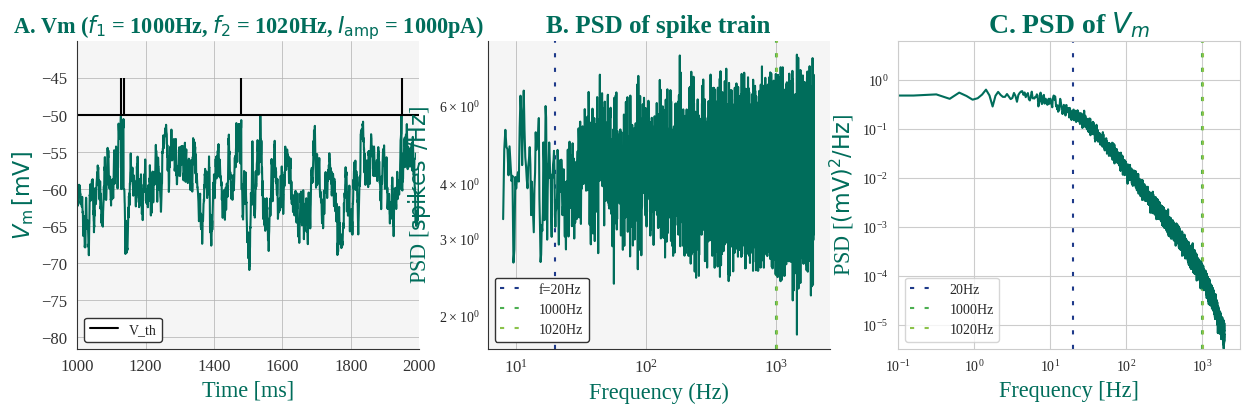

In [14]:
"""num_A=1"""
plot_results(sim_time=100e3, tau_syn_ex=2, tau_m = 10,
             a_values=[1000],f_values=[1000], delay_sd=0.25, delay_mean=1,
             noisy=True, SD_values=[250],num_A=1, weight=1, common_noise=False,
             bin_size=0.25,xLim=1,second_sine=True, beat=20, harmonics_beat=1,harmonics=1,
             log=True, resolution=0.25)

,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat),Population spike-rate
0,"[1000, 1020]",20,1000,-50.001138,10.58,5.85,4.18,765.44,1.02,5.71,2.82,1.0,5.7,579.63


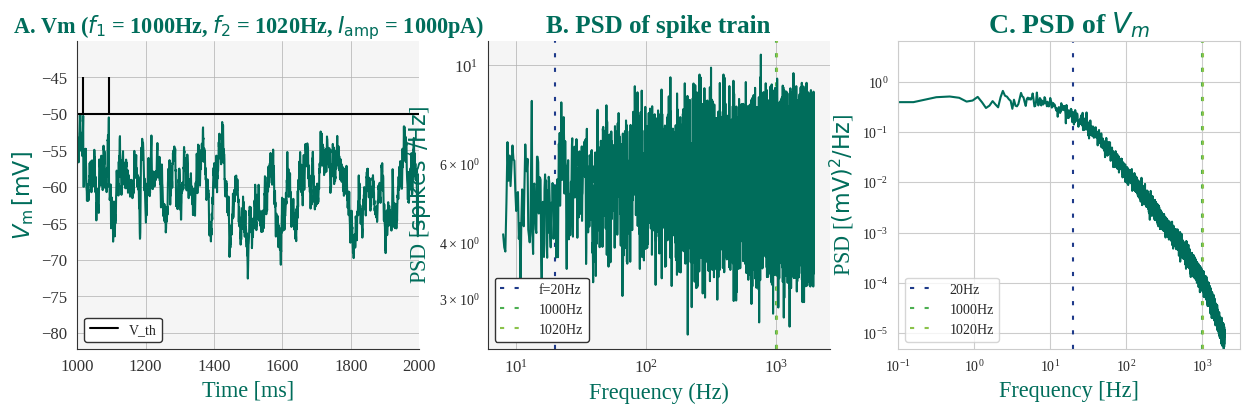

In [17]:
"""num_A=100"""
plot_results(sim_time=100e3, tau_syn_ex=2, tau_m = 10,
             a_values=[1000],f_values=[1000], delay_sd=0.25, delay_mean=1,
             noisy=True, SD_values=[250],num_A=100, weight=1, common_noise=False,
             bin_size=0.25,xLim=1,second_sine=True, beat=20, harmonics_beat=1,harmonics=1,
             log=True, resolution=0.25)

,Input Frequency (Hz),Beat Frequency (Hz),Current Amplitude (pA),Max Vm (mV),Max FFT Amplitude [(spikes per sec)/Hz],PSD Amplitude for f [(spikes pr sec)/Hz],PSD Amplitude for f2-f1 [(spikes pr sec)/Hz],Frequency at max (Hz),SNR (f),noise average,Spike Rate (spikes/s),SNR (beat),noise average (beat),Population spike-rate
0,"[1000, 1020]",20,1000,-50.000027,11699.48,384.42,14.14,20.0,1.2,320.82,155.71,101.7,320.8,58080.45


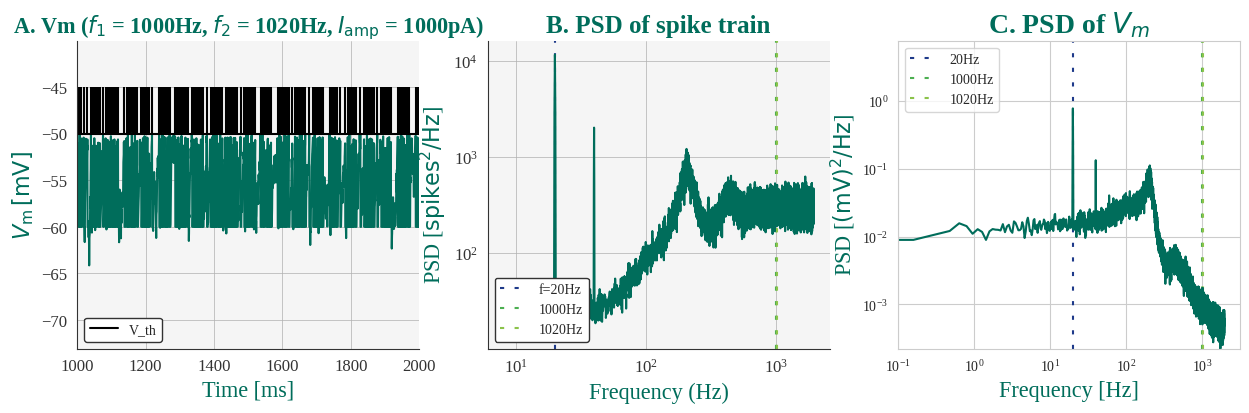

In [18]:
"""num_A=10000"""
plot_results(sim_time=100e3, tau_syn_ex=2, tau_m = 10,
             a_values=[1000],f_values=[1000], delay_sd=0.25, delay_mean=1,
             noisy=True, SD_values=[250],num_A=10000, weight=1, common_noise=False,
             bin_size=0.25,xLim=1,second_sine=True, beat=20, harmonics_beat=1,harmonics=1,
             log=True, resolution=0.25)